# Support Vector Machines from scratch

In [59]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxmat
from cvxopt import solvers as solver
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [72]:
def generate_data(n_samples=200, n_features=2, centers=2, center_box=(-15, 15), cluster_std=1):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      center_box=center_box, cluster_std=cluster_std)
    y[y == 0] = -1 
    y = y.astype(float)
    
    st = StandardScaler()
    X_s = st.fit_transform(X)
    return X_s, y

In [73]:
X, y = generate_data()

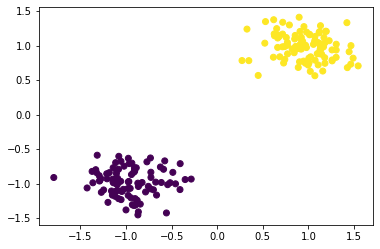

In [74]:
plt.scatter(X[:, 0], X[:, 1], c=y)

$$
    \large
    \boldsymbol{K}_{ij} = \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j)
$$

$$
    \large
    \max_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{K}_{ij} \\
    \large
    \min_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{K}_{ij} -  \sum_{i=1}^{N}\sigma_i  
$$


$$
\large
    P_{ij} = y_i y_j \boldsymbol{K}_{ij}
$$

$$
    \large
    \boldsymbol{w} = \sum_{i=1}^{N} y_i \sigma_i\boldsymbol{x}_i
$$

$$
    \large
    b = y_s - \sum_{m \in S} \sigma_m y_m \phi(\boldsymbol{x}_m)^\top \phi(\boldsymbol{x}_s) \\
    \text{where} \; S \; \text{is the set of support vectors such as} \; \sigma_i > 0
$$

- Compute $\boldsymbol{P}$.
- Compute $\boldsymbol{w}$.
- Find the support vectors $S$ by finding any data point where $\sigma_i > 0$.
- Compute $b$.
- To predict, compute:
$$
    \large
    y_{test} = \text{sign}\left(\boldsymbol{w}^\top \phi({\boldsymbol{x}_{test}}) + b \right)
$$

CVXOPT form:
$$
    \min \frac{1}{2} \boldsymbol{x}^\top\boldsymbol{P}\boldsymbol{x} + \boldsymbol{q}^\top\boldsymbol{x}\\
    \text{s.t.} \\
    \boldsymbol{G}\boldsymbol{x} \leq h \\
    \boldsymbol{A}\boldsymbol{x} = 0
$$

In matrix form the dual optimization is:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

In [75]:
def linear_kernel(X_1, X_2):
    return np.dot(X_1, X_2)

In [76]:
class SupportVectorClassifier():
    def __init__(self, kernel):
        self.kernel = kernel
        
    def fit(self, X, y):
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)
        y = y.astype(float)
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i, :], X[j, :])
        q = cvxmat(np.ones((n_samples, 1)) * -1.)
        h = cvxmat(np.zeros((n_samples, 1)))
        G = cvxmat(np.eye(n_samples) * -1.)
        A = cvxmat(y.T)
        b = cvxmat(0.)
        P = cvxmat(np.outer(y, y) * K)
        
        sigma = np.array(solver.qp(P, q, G, h, A, b)['x'])
        
        sv_idx = sigma > 1e-5
        self.sv_sigma = np.expand_dims(sigma[sv_idx], axis=1)
        sv_idx = np.squeeze(sv_idx)
        self.sv = X[sv_idx, :]
        self.sv_y = y[sv_idx]
        
        w = np.sum(self.sv_y * self.sv_sigma * self.sv, axis=0)
        self.w = np.expand_dims(w, axis=1)
        
        # Gather all pairwise distance of the support vectors
        idx = sv_idx.astype(int).nonzero()[0]
        b = 0
        sv_sigma_flat = self.sv_sigma.flatten()
        sv_y_flat = self.sv_y.flatten()
        for i in range(len(idx)):
            b += self.sv_y[i]
            b -= np.sum(sv_sigma_flat * sv_y_flat * K[idx[i], sv_idx])
        b /= len(idx)
        self.b = b
        
    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))

In [77]:
svc = SupportVectorClassifier(linear_kernel)
svc.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -4.6357e+00 -7.5062e+00  4e+02  2e+01  1e+00
 1: -1.2385e+00 -1.8427e+00  1e+01  7e-01  5e-02
 2: -1.9020e-01 -1.3544e+00  1e+00  2e-16  8e-16
 3: -4.9916e-01 -8.6321e-01  4e-01  1e-16  6e-16
 4: -6.7857e-01 -8.9076e-01  2e-01  5e-16  4e-16
 5: -8.3833e-01 -8.4801e-01  1e-02  2e-16  6e-16
 6: -8.4535e-01 -8.4544e-01  1e-04  7e-16  6e-16
 7: -8.4542e-01 -8.4542e-01  1e-06  1e-16  6e-16
 8: -8.4542e-01 -8.4542e-01  1e-08  3e-16  6e-16
Optimal solution found.


In [78]:
pred = svc.predict(X)

In [79]:
def f(x, w, b):
    return (-w[0] * x - b) / w[1]

In [80]:
def plot_svc(X, y, svc, pred):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.scatter(svc.sv[:, 0], svc.sv[:, 1])
    axis_min, axis_max = plt.gca().get_xlim()
    
    w = svc.w
    
    a = -w[0] / w[1]
    xx = np.linspace(axis_min, axis_max)
    yy = a * xx - svc.b[0] / w[1]

    # Plot the hyperplane
    b = svc.sv[np.where(svc.sv_y == 1.)[0]][0]
    
    yy_down = a * xx + (b[1] - a * b[0])
    b = svc.sv[np.where(svc.sv_y == -1.)[0]][0]
    yy_up = a * xx + (b[1] - a * b[0])
    
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

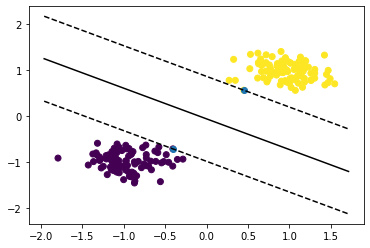

In [81]:
plot_svc(X, y, svc, pred)

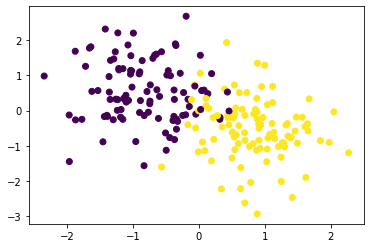

In [82]:
X, y = generate_data(n_samples=200, n_features=2, centers=2, center_box=(-5, 5), cluster_std=3)
plt.scatter(X[:, 0], X[:, 1], c=y)